In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  5 22:18:19 2016
test
@author: lywen
"""

import pandas as pd
import numpy as np
from scipy import stats
from help.help import timedelta
def gettestdata():
    
        colname = [
                      'id',                 
                     'trade_id',
                     'currency_pair',
                     'sell_currency',
                     'buy_currency',
                     'sell_amount',
                     'trade_date',##交易日期
                     'determined_date',##厘定日期
                     'delivery_date',##交割日期
                     'trp',##目标收益
                     'rate', ##锁定汇率
                     'determined_date_rate'
                        ]
        
        data = [['id_0','trade_id_0','USDCNH','USD','CNH',1,'2015-07-24','2016-07-21','2016-07-23',0.05,6.68,6.67],
                ['id_1','trade_id_0','USDCNH','USD','CNH',1,'2015-08-24','2016-08-21','2016-08-23',0.05,6.68,6.67],
                ['id_2','trade_id_0','USDCNH','USD','CNH',1,'2015-09-24','2016-09-21','2016-09-23',0.05,6.68,6.67],
                ['id_3','trade_id_1','USDCNH','USD','CNH',1,'2016-08-24','2016-08-26','2016-08-26',0.05,6.68,6.67],
                ['id_4','trade_id_1','USDCNH','USD','CNH',1,'2016-09-24','2016-09-26','2016-09-26',0.05,6.68,6.69],
                ['id_5','trade_id_1','USDCNH','USD','CNH',1,'2016-10-24','2016-10-26','2016-10-26',0.05,6.68,None],
                ['id_6','trade_id_2','USDCNH','USD','CNH',1,'2016-09-24','2016-10-24','2016-10-25',0.05,6.68,None],
                ['id_7','trade_id_2','USDCNH','USD','CNH',1,'2016-10-24','2016-11-25','2016-11-25',0.05,6.68,None],
                ['id_8','trade_id_2','USDCNH','USD','CNH',1,'2016-11-24','2016-12-25','2016-12-25',0.05,6.68,None],
               ]

        data = pd.DataFrame(data,columns=colname)
        data['trade_date'] = data['trade_date'].astype(np.datetime64)
        data['determined_date'] = data['determined_date'].astype(np.datetime64)

        data['delivery_date'] = data['delivery_date'].astype(np.datetime64)

        return data.to_dict('records')
        
        
def getdayspot(Now):
    """
    获取汇率对历史记录时间序列
    code:汇率对
    mongo:数据库连接实例
    
    """
    date = pd.date_range('2016-01-01',Now)
    n = date.shape[0]
    
    st = stats.norm(loc=6.68,scale=0.1)
    value = st.rvs(n)
    spot = pd.DataFrame({'Time':date,'Close':value})
    return spot[['Time','Close']]
    
def lagdata(spot,lags=30):
    """
    spot：每天外汇收益率时间序列
    lags：时间长度
    序列指定时间长度的收益率
    """
    #spot = datafill(spot)
    
    spot['Close_%d'%lags] = np.repeat(None,lags).tolist() + spot['Close'].values[:-lags].tolist()
    spot =  spot.dropna()
    
    
    spot['Close_%d_rate'%lags] = (spot['Close'] - spot['Close_%d'%lags])/spot['Close_%d'%lags]
    
    return spot['Close_%d_rate'%lags].values
    
    
def getDataFromMongo(Now):
        """
        from mongo get the currency_pairs and bank_rate
        """
        def getS():
                   st = stats.norm(loc=6.68,scale=0.1)
                   value = st.rvs(1) 
                   return value
             
        S=getS()##获取实时汇率
        trfdata={}
        data = gettestdata()
        dayspot = getdayspot('2016-10-05')
        spot = lagdata(dayspot,30)
        if data !=[]:
           
           
           #mongo = mongodb()
           trfdata = {}
           for lst in data:
               ##获取厘定日汇率，未到立定日，以None填充
               
               SellRate = 0.015
               BuyRate  = 0.0322
               
               
                
               if trfdata.get(lst['trade_id']) is None:
                   lags = (lst['delivery_date'] -lst['trade_date']).days
                   trfdata[lst['trade_id']] = {'orderlist':[],
                                                'spotList':spot,##lags时间段收益时间序列
                                                 'S':S,##实时汇率
                                                 'SellRate':SellRate,##卖出货币拆解利率
                                                 'BuyRate':BuyRate,##买入货币拆解利率
                                                 'K':float(lst.get('rate')),##锁定汇率
                                                 'TIV':float(lst.get('trp')),##目标收益
                                                 'lags':lags,##每期时间间隔
                                                 'Now':Now,##损益计算时间
                                                 }
               trfdata[lst['trade_id']]['orderlist'].append(lst)
        return trfdata,data

In [ ]:
dayspot = getdayspot('2016-10-05')
spot = lagdata(dayspot,30)

In [1]:
from database.database import mongodb
import pandas as pd
import numpy as np
from ggplot import *
%matplotlib inline
from help.help import strTostr

In [2]:
mongo = mongodb()

In [ ]:
#data = mongo.select('kline',{'type':'5'})


In [3]:
data = mongo.select('kline',{'type':'5','code':'USDCAD'})
data = pd.DataFrame(data)
data['Close'] = data['Close']/data['PriceWeight']
data['High'] = data['High']/data['PriceWeight']
data['Open'] = data['Open']/data['PriceWeight']
data['LastClose'] = data['LastClose']/data['PriceWeight']
data['Low'] = data['Low']/data['PriceWeight']
data = data[['Close','High','LastClose','Low','Open','Time','code']]
data['Time'] = data['Time'].map(lambda x:strTostr(x,'%Y-%m-%d %H:%M:%S','%Y-%m-%d'))

In [ ]:
#data.to_csv('../data.csv',index=False)

In [4]:
import datetime as dt

def timedelta(s,day,format='%Y-%m-%d'):
   try:
      return (dt.datetime.strptime(s,format)+dt.timedelta(day)).strftime(format)
   except:
       return None

In [5]:
def dateseris(mindate,maxdate):
        
        date = timedelta(mindate,1)
        series = []
        while maxdate>=date:
            series.append(date)

            date = timedelta(date,1)

        return series
def datafill(spot):
    """填充无交易日期的汇率
        以上一个交易日的的收盘价进行填充
    """
   

    spot = pd.merge(pd.DataFrame(dateseris(spot['Time'].min(),spot['Time'].max()),columns=['Time']),spot[['Time','Close']],on=['Time'],how='left' )
    spot = spot.sort_values('Time')
    for i in range(spot.shape[0]):
        if spot['Close'].values[i].__str__()=='nan':
            spot['Close'].values[i] = spot['Close'].values[i-1]
    return spot

def lagdata(spot,lags=[30,60,180]):
    """
    spot：每天外汇收益率时间序列
    lags：时间长度
    序列指定时间长度的收益率
    """
    spot = datafill(spot)
    for lag in lags:
        
        spot['Close_%d'%lag] = np.repeat(None,lag).tolist() + spot['Close'].values[:-lag].tolist()
        spot['Close_%d_rate'%lag] = (spot['Close'] - spot['Close_%d'%lag])/spot['Close_%d'%lag]

    spot =  spot.dropna()
    return spot

In [6]:
spot = lagdata(data,[30,60,90,120,150,180,210,240])
spot['Time'] = spot['Time'].astype(np.datetime64)

In [7]:
temp = None
for group in ['Close_30_rate','Close_60_rate','Close_90_rate','Close_120_rate','Close_150_rate','Close_180_rate','Close_210_rate','Close_240_rate']:
    tm = spot[['Time',group]]
    tm['group'] = group
    tm.columns = ['Time','rate','group']
    if temp is None:
        temp = tm
        
    else:
        temp = temp.append(tm)
       

/Users/lywen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
 
    
p = ggplot(aes(x='rate',group='group',color='group'),temp)+geom_density()


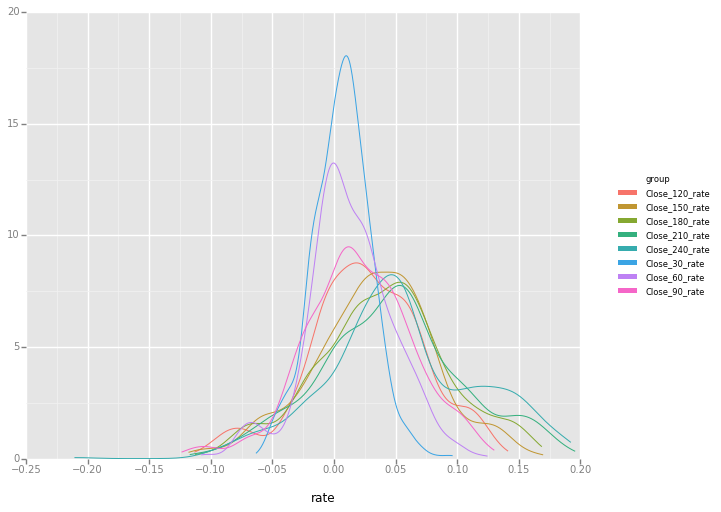

<ggplot: (296877365)>

In [9]:
p